In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Importing csv files for Water, Power and Weather Data into Dataframes
water = pd.read_csv("../raw_data/water_usage_edit.csv")
power = pd.read_csv("../raw_data/elec_usage_edit.csv")
weather = pd.read_csv("../raw_data/weather_data_edit.csv", encoding="latin1")

In [2]:
# Converting Date Column in Water Dataframe to Datetime in the format of Year/Month/Day and then printing out the Dataframe
water['Date'] = pd.to_datetime(water['Date'])
water['Date'] = water['Date'].dt.strftime("%Y/%m/%d")
water

,Date,Usage(L)
0,2013/10/21,97
1,2013/10/22,228
2,2013/10/23,211
3,2013/10/24,219
4,2013/10/25,196
...,...,...
3275,2022/09/24,41
3276,2022/09/25,1
3277,2022/09/26,0
3278,2022/09/27,66


In [3]:
# Converting Date Column in Power Dataframe to Datetime in the format of Year/Month/Day and then printing out the Dataframe
power['Date'] = pd.to_datetime(power['Date'])
power['Date'] = power['Date'].dt.strftime("%Y/%m/%d")
power

,Date,Usage(kWh)
0,2013/10/21,975
1,2013/10/22,1880
2,2013/10/23,1879
3,2013/10/24,1858
4,2013/10/25,1896
...,...,...
3275,2022/09/24,1062
3276,2022/09/25,766
3277,2022/09/26,769
3278,2022/09/27,1602


In [4]:
# Converting Date Column in Weather Dataframe to Datetime in the format of Year/Month/Day and then printing out the Dataframe
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Date'] = weather['Date'].dt.strftime("%Y/%m/%d")

# Filtering Weather Data to match up with the dates of the Water and Power Data
weather = weather.loc[(weather['Date'] >= '2013/10/21') & (weather['Date'] <= '2022/08/31')]
weather

,Date,Rainfall (mm),Max Temp (°C),Min Temp (°C)
10612,2013/10/21,12.4,16.2,8.9
10613,2013/10/22,3.5,15.9,11.5
10614,2013/10/23,0.6,12.2,7.4
10615,2013/10/24,18.4,13.9,6.9
10616,2013/10/25,6.1,15.8,8.7
...,...,...,...,...
13844,2022/08/27,0.0,21,10.2
13845,2022/08/28,0.0,22,11.6
13846,2022/08/29,0.0,24,12.7
13847,2022/08/30,0.0,21.3,12


In [5]:
# Merging Weather Dataframe with Water Dataframe to from 'alldata' dataframe
alldata = pd.merge(weather, water, how='outer', on='Date')


# Merging alldata dataframe and power dataframe
alldata = pd.merge(alldata, power, how='outer', on='Date')


# This means that now the alldata dataframe contains all of the information from the weather, water and power dataframes in one.


# Dropping all rows containing null values as prediction won't be possible without them.
alldata = alldata.dropna()


# Dropping row with index 2549 as method dropna() didn't work properly
alldata.drop([2549], axis=0, inplace=True)


# Converting column 'Rainfall (mm)' from Object to float
alldata['Rainfall (mm)'] = alldata['Rainfall (mm)'].astype(float)

#alldata["Max Temp (°C)"] = pd.to_numeric(alldata["Max Temp (°C)"], downcast="float")
alldata['Max Temp (°C)'] = alldata['Max Temp (°C)'].astype(float)
alldata['Min Temp (°C)'] = alldata['Min Temp (°C)'].astype(float)


# Appending new column called 'Avg Temp (°C)' to the end of alldata dataframe that's an average of the max and min temperatures.
#alldata['Avg Temp (°C)'] = alldata[['Max Temp (°C)','Min Temp (°C)']].mean()
alldata['Avg Temp (°C)'] = alldata[['Max Temp (°C)','Min Temp (°C)']].mean(axis=1)


# Printing out the top 5 entries in the alldata dataframe
alldata.head(5)

#writer = pd.ExcelWriter('alldata.xlsx')
#alldata.to_excel(writer)
#writer.save()




,Date,Rainfall (mm),Max Temp (°C),Min Temp (°C),Usage(L),Usage(kWh),Avg Temp (°C)
0,2013/10/21,12.4,16.2,8.9,97.0,975.0,12.55
1,2013/10/22,3.5,15.9,11.5,228.0,1880.0,13.70
2,2013/10/23,0.6,12.2,7.4,211.0,1879.0,9.80
3,2013/10/24,18.4,13.9,6.9,219.0,1858.0,10.40
4,2013/10/25,6.1,15.8,8.7,196.0,1896.0,12.25


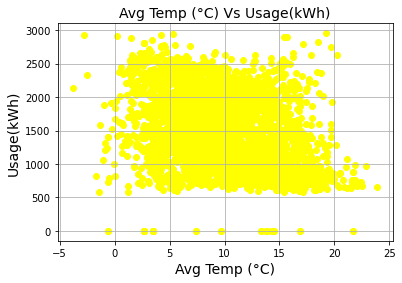

In [6]:
# Making a scatter plot to test for correlation
# 1611 is a big outlier so we need to remove it
alldata.drop([1611], axis=0, inplace=True)
plt.scatter(alldata['Avg Temp (°C)'], alldata['Usage(kWh)'], color='yellow')
plt.title('Avg Temp (°C) Vs Usage(kWh)', fontsize=14)
plt.xlabel('Avg Temp (°C)', fontsize=14)
plt.ylabel('Usage(kWh)', fontsize=14)
plt.grid(True)
plt.show()

array([[<AxesSubplot:title={'center':'Avg Temp (°C)'}>,
        <AxesSubplot:title={'center':'Usage(kWh)'}>]], dtype=object)

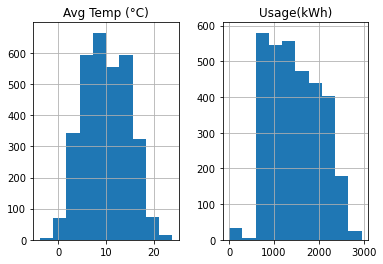

In [21]:
#Checking to see if the data contains a bell curve as would be expected
alldata.hist(column=['Avg Temp (°C)', 'Usage(kWh)'])

In [28]:
# Setting Independant Values to X and Dependant values to y
X = alldata[['Avg Temp (°C)','Rainfall (mm)', ]]
y = alldata['Usage(kWh)']

# Creating Linear Regression Object
regr = linear_model.LinearRegression()

# Calling fit() method which takes independent and dependent values as parameters and fills the regression object with data that describes the relationship
regr.fit(X,y)

# Prediction of power usage in first row using Average temp and Rainfall
predictPower = regr.predict([[12.4, 12.55]])

# Printing Power Usage Prediction
print('Predicted Power Usage: ', predictPower)

# Printing coefficient values for regression object
print('Coefficient Values: ', regr.coef_)

Predicted Power Usage:  [1380.60603403]
Coefficient Values:  [-44.44823177   1.6393053 ]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [29]:
# Setting Independant Values to X and Dependant values to y
X = alldata[['Max Temp (°C)', 'Min Temp (°C)', 'Rainfall (mm)', ]]
y = alldata['Usage(kWh)']

# Creating Linear Regression Object
regr = linear_model.LinearRegression()

# Calling fit() method which takes independent and dependent values as parameters and fills the regression object with data that describes the relationship
regr.fit(X,y)

# Prediction of power usage in first row using Max temp, Min temp and Rainfall
predictPower = regr.predict([[16.2, 8.9, 12.4]])

# Printing Power Usage Prediction
print('Predicted Power Usage: ', predictPower)

# Printing coefficient values for regression object
print('Coefficient Values: ', regr.coef_)

Predicted Power Usage:  [1372.32786274]
Coefficient Values:  [-28.93193417 -14.1319541    1.14180831]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
